#### LIBRARIES USED

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import time
from scipy.signal import convolve2d
import os

### City Model

The city is represented as a N x N grid, in which there is two kinds of agents, residents and merchants. The residents wants to be in a no so dense region of the city and the merchants want to be in a high density region.

#### FUNCTIONS'S DEFINITIONS

In [3]:
merchant_value = -1
vacancy_value = 0
resident_value = 1

# square neighborhood
# 1:= 3x3; 2:= 5x5; 3:= 7x7; ...
neighborhood = 2
kernel_side = (2*neighborhood+1)
max_neighbors = kernel_side**2 - 1

# densities
minimal_neighbors_resident_density = 0.25
maximal_neighbors_resident_density = 0.8
minimal_neighbors_merchant_density = 0.6
minimal_merchant_neighbors_resident_density = 0.2

# conditions of dissatisfaction Resident
minimal_neighbors_resident = np.round( max_neighbors * minimal_neighbors_resident_density )
maximal_neighbors_resident = np.round( max_neighbors * maximal_neighbors_resident_density )

minimal_merchant_neighbors_resident = np.round(max_neighbors * minimal_merchant_neighbors_resident_density)
maximal_merchant_neighbors_resident = max_neighbors

# conditions of dissatisfaction Merchant
minimal_neighbors_merchant = np.round( max_neighbors * minimal_neighbors_merchant_density )
maximal_neighbors_merchant = max_neighbors

minimal_resident_neighbors_merchant = 0
maximal_resident_neighbors_merchant = max_neighbors

In [4]:
def plot_grid(agents, grid = False):
    # creates a discrete colormap
    vacancy = np.array([147.0/255, 148.0/255, 150.0/255])  # grey
    agent =  np.array([255.0/255, 255.0/255, 0.0/255])     # red 
    cyan =  np.array([0.0/255, 200.0/255, 255.0/255])      # cyan
    cmap = colors.ListedColormap([cyan, vacancy, agent])
    # determines the limits of each color:
    bounds = [merchant_value, vacancy_value, resident_value, resident_value + 1]            
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(agents, cmap=cmap, norm=norm)

    # hide axis values
    plt.xticks([])  
    plt.yticks([])  

    # draws gridlines
    if grid:
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-0.5, agents.shape[1]))
        ax.set_yticks(np.arange(-0.5, agents.shape[0]))

    plt.show()
    plt.close()

In [5]:
def save_image(agents, grid = False, fileName = "city"):
    # creates a discrete colormap
    vacancy = np.array([147.0/255, 148.0/255, 150.0/255])  # grey
    agent =  np.array([255.0/255, 255.0/255, 0.0/255])     # red 
    cyan =  np.array([0.0/255, 200.0/255, 255.0/255])      # cyan
    cmap = colors.ListedColormap([cyan, vacancy, agent])
    # determines the limits of each color:
    bounds = [merchant_value, vacancy_value, resident_value, resident_value + 1]            
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(agents, cmap=cmap, norm=norm)

    # hide axis values
    plt.xticks([])  
    plt.yticks([])  

    # draws gridlines
    if grid:
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-0.5, agents.shape[1]))
        ax.set_yticks(np.arange(-0.5, agents.shape[0]))

    plt.savefig(fileName + ".png")
    plt.close()

In [6]:
def create_city(N, agentDensity, residentRelativeDensity, plot = True):
    # creates a city without borders, that will be a toroidal grid
    city = np.zeros(N*N, dtype=np.int16)
    agents = int(agentDensity*N*N)
    residents = int(residentRelativeDensity*agents)
    merchants = agents - residents

    # insert agents according to their densities
    for i in range(N*N):
        if i < residents:
            city[i] = resident_value
        elif residents <= i < residents + merchants:
            city[i] = merchant_value
        else:
            break

    # shuffle agents places
    np.random.shuffle(city)
    # reshape city array to matrix
    city = city.reshape((N,N)) 

    if plot:
        plot_grid(city)
    
    return city

In [7]:
# code by LUCA MINGARELLI https://lucamingarelli.com/Teaching/schelling.html
KERNEL = np.ones((kernel_side, kernel_side), dtype=np.int8)
middle = int(kernel_side/2)
KERNEL[middle][middle] = 0

def evolve(M, boundary='wrap'):
    kws = dict(mode='same', boundary=boundary)
    Resident_neighs = convolve2d(M == resident_value,  KERNEL, **kws)
    Merchant_neighs = convolve2d(M == merchant_value,  KERNEL, **kws)
    Neighs = convolve2d(M != vacancy_value,  KERNEL, **kws)

    # conditions of dissatisfaction
    Resident_dissatisfied = ((((Neighs < minimal_neighbors_resident) | (Neighs > maximal_neighbors_resident)) |                                  # minimal and maximal neighbors                   
                           ((Merchant_neighs < minimal_merchant_neighbors_resident) | (Merchant_neighs > maximal_merchant_neighbors_resident))) & # minimal and maximal merchant neighbors 
                           (M == resident_value))
    Merchant_dissatisfied = ((((Neighs < minimal_neighbors_merchant) | (Neighs > maximal_neighbors_merchant)) |                                  # minimal and maximal neighbors   
                           ((Resident_neighs < minimal_resident_neighbors_merchant) | (Resident_neighs > maximal_resident_neighbors_merchant))) & # minimal and maximal resident neighbors 
                           (M == merchant_value))
    M[Resident_dissatisfied | Merchant_dissatisfied] = vacancy_value
    vacant = (M == vacancy_value).sum()

    N_Resident_dissatisfied, N_Merchant_dissatisfied = Resident_dissatisfied.sum(), Merchant_dissatisfied.sum()
    filling = np.full(vacant, vacancy_value, dtype=np.int8)
    filling[:N_Resident_dissatisfied] = resident_value
    filling[N_Resident_dissatisfied:N_Resident_dissatisfied + N_Merchant_dissatisfied] = merchant_value
    np.random.shuffle(filling)
    M[M==vacancy_value] = filling

In [8]:
def simulate(city, timeSteps = 1000, plot = False, plotEnd = True, saveImage = False, fileName = "city"):
    for i in range(timeSteps):
        # stop condition
        if i%int(timeSteps/10) == 0:
            oldCity = np.copy(city)
            evolve(city)
            dif = oldCity - city
            if all(all(element == 0) for element in dif):
                break

        else:
            evolve(city)

        # time steps in which the city is plotted
        step = 100
        if i != 0 and i%step == 0 and plot:
            plot_grid(city)
            time.sleep(0.1)
            display.clear_output(wait=True)
                
    if plotEnd:
        display.clear_output(wait=True)
        plot_grid(city)

    if saveImage:
        save_image(city, fileName = fileName)

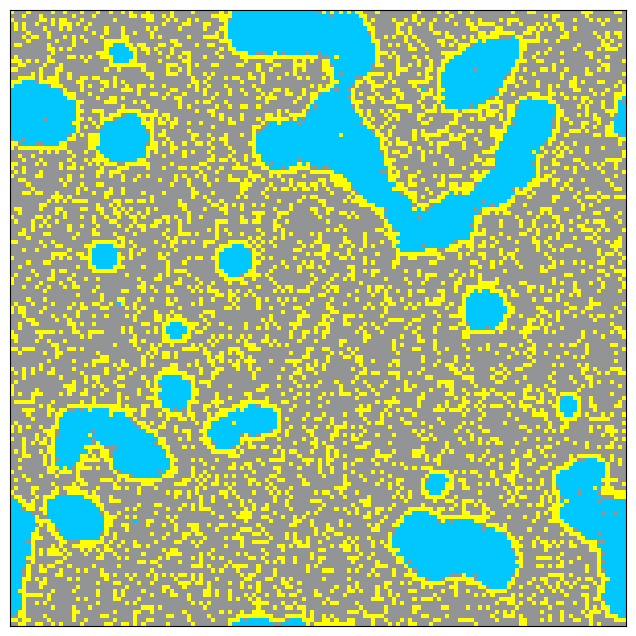

In [9]:
N = 150
agentDensity = 0.4
residentRelativeDensity = 0.6
timeSteps = 1000
plot = True
analizeStart = False

# creates a city
city = create_city(N, agentDensity, residentRelativeDensity)

if analizeStart:
    if int(input()):
        simulate(city, timeSteps, plot = plot)
else:
    simulate(city, timeSteps, plot = plot)

### Calculating Clustering

In [10]:
def clustering_level(M, boundary='wrap'):
    kws = dict(mode='same', boundary=boundary)
    Resident_neighs = convolve2d(M == resident_value,  KERNEL, **kws)
    Merchant_neighs = convolve2d(M == merchant_value,  KERNEL, **kws)
    Neighs = convolve2d(M != vacancy_value,  KERNEL, **kws)
    
    # calculate clustering level of merchants
    side = M.shape[0]
    clustering = 0
    agents_with_neighs = 0

    for i in range(side):
        for j in range(side):
            if M[i][j] != vacancy_value and Neighs[i][j] != 0:
                agents_with_neighs += 1
                if M[i][j] == resident_value:
                    clustering += Resident_neighs[i][j]/(Neighs[i][j]*residentRelativeDensity)
                elif M[i][j] == merchant_value:
                    clustering += Merchant_neighs[i][j]/(Neighs[i][j]*(1-residentRelativeDensity))
                
    clustering = clustering/agents_with_neighs
    
    return clustering

### Hoshen-Kopelman Algorithm

In [11]:
def plot_generic_grid(matrix, grid = False):
    n,m = np.array(matrix).shape
    colorDict = dict()
    for i in range(n):
        for j in range(m):
            if matrix[i][j] not in colorDict:
                rnd1 = np.random.random()
                rnd2 = np.random.random()
                rnd3 = np.random.random()
    
                color = np.array([rnd1,rnd2,rnd3])
                
                colorDict[matrix[i][j]] = color

    colorArray = np.zeros((len(colorDict),3))
    i = 0
    for color in list(colorDict.values()):
        colorArray[i] = color
        i += 1
        
    cmap = colors.ListedColormap(colorArray)
    # determines the limits of each color:
    bounds = np.array(sorted(list(colorDict.keys())), dtype = float)
    bounds = np.append(bounds, bounds[-1] + 1)

    # by hand correction for better visualization
    for i in range(len(bounds)):
        bounds[i] = bounds[i] - 0.5
        
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(matrix, cmap=cmap, norm=norm)

    # hide axis values
    plt.xticks([])  
    plt.yticks([])  

    # draws gridlines
    if grid:
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-0.5, agents.shape[1]))
        ax.set_yticks(np.arange(-0.5, agents.shape[0]))

    plt.show()
    plt.close()

In [12]:
class HoshenKopelman():

    def __init__(self, matrix):
        self.matrix = matrix
        self.labelsArray = np.arange(0,np.size(matrix) + 1, dtype = np.int16)
        self.labels = np.zeros(matrix.shape, dtype = np.int16)
        self.algorithmRan = False 
        
    def find(self, i):
        j = i
    
        while self.labelsArray[j] != j:
            j = self.labelsArray[j]
    
        return j
    
    def union(self, i, j):  
        index = self.find(j)
        value = self.find(i)
        
        self.labelsArray[index] = value
        
    def hk(self, target_value):
        n, m = self.matrix.shape
        largest_label = 0

        for j in range(m):
            for i in range(n):
                if self.matrix[i][j] == target_value:
                    if i > 0: up = self.matrix[i-1][j] 
                    else: up = None
    
                    if j > 0: left = self.matrix[i][j-1]
                    else: left = None
    
                    if left != target_value and up != target_value:
                        largest_label += 1
                        self.labels[i][j] = largest_label
                    
                    elif left == target_value and up != target_value:
                        self.labels[i][j] = self.find(self.labels[i][j-1])
    
                    elif left != target_value and up == target_value:
                        self.labels[i][j] = self.find(self.labels[i-1][j])
    
                    else:
                        smaller = min(self.labels[i][j-1], self.labels[i-1][j])
                        bigger = max(self.labels[i][j-1], self.labels[i-1][j])
                        self.union(smaller, bigger)
                        self.labels[i][j] = self.find(smaller)
    
        for j in range(m):
            for i in range(n):
                if self.labels[i][j]:
                    self.labels[i][j] = self.find(self.labels[i][j])

        self.algorithmRan = True
        
        return self.labels

    def cluster_data(self):
        if self.algorithmRan:
            n, m = self.labels.shape
            clustersLabels = set()
            
            for i in range(n):
                for j in range(m):
                    if self.labels[i][j] not in clustersLabels and self.labels[i][j] != 0:
                        clustersLabels.add(self.labels[i][j])
                        
            numClusters = len(clustersLabels)
            clustersSizes = dict()

            clustersSizesAverage = 0
            for label in clustersLabels:
                size = (self.labels == label).sum()
                clustersSizesAverage += size
                clustersSizes[label] = size

            clustersSizesAverage = float(clustersSizesAverage)/numClusters

            return numClusters, clustersSizes, clustersSizesAverage
            
        else:
            print('Run the algorithm first')    

### Example

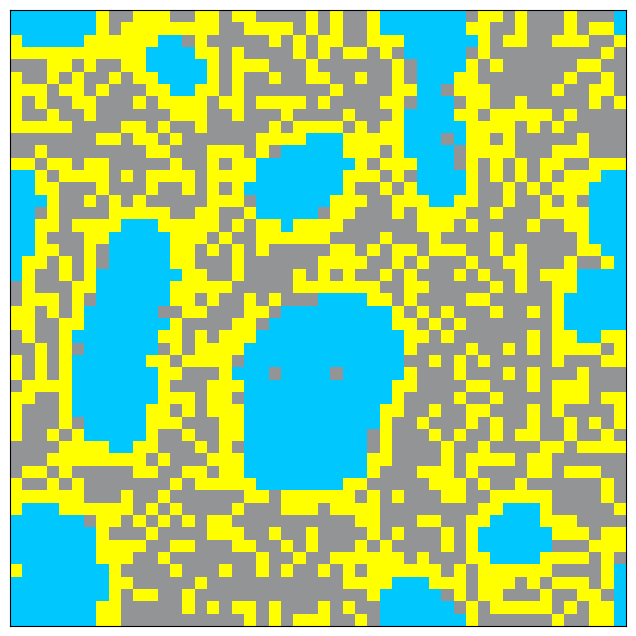

1.571266907762034


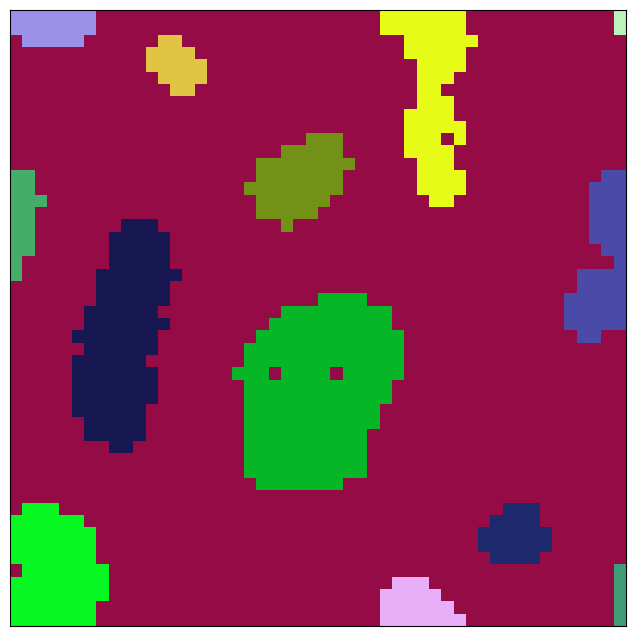

13
{1: 19, 2: 17, 35: 2, 3: 67, 36: 5, 6: 108, 12: 17, 14: 166, 15: 43, 24: 67, 25: 21, 28: 23, 31: 45}
46.15384615384615


In [25]:
N = 50
agentDensity = 0.6
residentRelativeDensity = 0.6
timeSteps = 5000
plot = False
analizeStart = False
saveImage = False

# creates a city
city = create_city(N, agentDensity, residentRelativeDensity)

if analizeStart:
    if int(input()):
        simulate(city, timeSteps, plot = plot)
else:
    simulate(city, timeSteps, plot = plot, plotEnd = True, saveImage = saveImage, fileName = 'example')

clusteringLevel = clustering_level(city)
print(clusteringLevel)

HK_class = HoshenKopelman(city)
labels = HK_class.hk(merchant_value)
numClusters, clustersSizes, clustersSizesAverage = HK_class.cluster_data()
plot_generic_grid(labels)
print(numClusters)
print(clustersSizes)
print(clustersSizesAverage)

### Charactertic time ~ 3000 time steps

In [58]:
N = 100
agentDensity = 0.3
residentRelativeDensity = 0.6
timeStepsArray = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000] 
simulations = 10
plot = False
analizeStart = False
saveImage = False

results = dict()

for i in range(len(timeStepsArray)):
    timeSteps = timeStepsArray[i]
    print(timeSteps)
    numClustersAverage = 0
    clustersSizesAverageAverage = 0
    
    for j in range(simulations):
    
        # creates a city
        city = create_city(N, agentDensity, residentRelativeDensity, plot = plot)
        
        if analizeStart:
            if int(input()):
                simulate(city, timeSteps, plot = plot)
        else:
            simulate(city, timeSteps, plot = plot, plotEnd = False, saveImage = saveImage, fileName = 'example')
        
        HK_class = HoshenKopelman(city)
        labels = HK_class.hk(merchant_value)
        numClusters, clustersSizes, clustersSizesAverage = HK_class.cluster_data()
    
        numClustersAverage += numClusters
        clustersSizesAverageAverage += clustersSizesAverage

    numClustersAverage = float(numClustersAverage)/simulations
    clustersSizesAverageAverage = float(clustersSizesAverageAverage)/simulations

    results[timeSteps] = (numClustersAverage, clustersSizesAverageAverage)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000


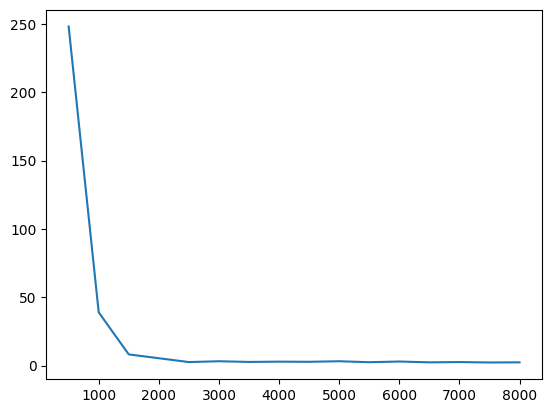

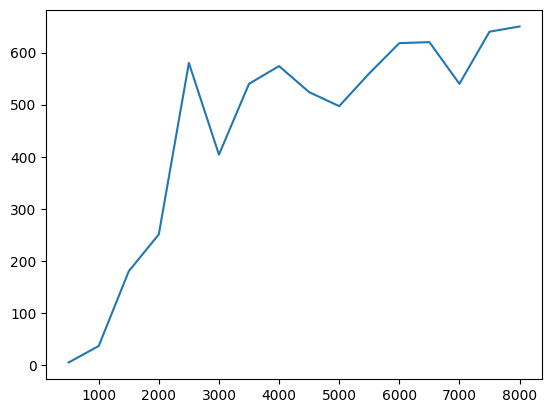

In [59]:
numClustersAverage = []
clustersSizesAverage = []
for value in list(results.values()):
    numClustersAverage.append(value[0])
    clustersSizesAverage.append(value[1])

plt.figure()
plt.plot(list(results.keys()), numClustersAverage)
plt.show()

plt.figure()
plt.plot(list(results.keys()), clustersSizesAverage)
plt.show()

In [60]:
for key, value in results.items():
    print(key, value)

500 (248.2, 5.2379625602309385)
1000 (39.0, 36.850370173470644)
1500 (8.2, 180.3230103230103)
2000 (5.4, 251.14285714285717)
2500 (2.6, 580.0)
3000 (3.2, 404.0)
3500 (2.7, 540.0)
4000 (2.9, 574.0)
4500 (2.8, 524.0)
5000 (3.2, 497.14285714285717)
5500 (2.5, 560.0)
6000 (3.0, 618.0)
6500 (2.4, 620.0)
7000 (2.6, 540.0)
7500 (2.3, 640.0)
8000 (2.4, 650.0)


### Calculate clustering for many cases [for 3000 time steps, 1 simulations runs, on average, in 19 seconds]

In [1]:
start = time.time()

doYouReallyWannaRunThis = False

if doYouReallyWannaRunThis:
    N = 150
    agentDensityArray = np.linspace(0.1,1,10)
    residentRelativeDensityArray = np.linspace(0.1,0.9,9)
    timeSteps = 3000
    simulations = 20
    plot = False
    saveImage = False
    
    if saveImage:
        folder = os.getcwd()
        files = os.listdir(folder)
        
        for file in files:
            if file.endswith(".png"):
                filePath = os.path.join(folder, file)
                os.remove(filePath)
    
    numClustersAverageDict = dict()
    numClustersDeviationDict = dict()
    clustersSizesAverageDict = dict()
    clustersSizesDeviationDict = dict()
    
    for agentDensity in agentDensityArray:
        for residentRelativeDensity in residentRelativeDensityArray:
            numClustersArray = np.zeros(simulations)
            clustersSizesAverageArray = np.zeros(simulations)
            numClustersDeviation = 0
            clustersSizesDeviation = 0
            
            fileName = f"({np.round(agentDensity,3)},{np.round(residentRelativeDensity,3)})"
            for i in range(simulations):
                # creates a city
                city = create_city(N, agentDensity, residentRelativeDensity, plot = plot)
    
                if i == simulations - 1:
                    simulate(city, timeSteps, plot = plot, plotEnd = False, saveImage = saveImage, fileName = fileName)
                    
                else:
                    simulate(city, timeSteps, plot = plot, plotEnd = False)
    
                HK_class = HoshenKopelman(city)
                HK_class.hk(merchant_value)
                numClusters, clustersSizes, clustersSizesAverageAcquired = HK_class.cluster_data()
                numClustersArray[i] = numClusters    
                clustersSizesAverageArray[i] = clustersSizesAverageAcquired
    
            numClustersAverage = float(numClustersArray.sum())/simulations
            clustersSizesAverage = float(clustersSizesAverageArray.sum())/simulations
    
            difSquaredNumClusters = 0
            difSquaredClustersSizes = 0
            for i in range(simulations):
                difSquaredNumClusters += (numClustersArray[i] - numClustersAverage)*(numClustersArray[i] - numClustersAverage)
                difSquaredClustersSizes += (clustersSizesAverageArray[i] - clustersSizesAverage)*(clustersSizesAverageArray[i] - clustersSizesAverage)
    
            numClustersDeviation = np.sqrt(float(difSquaredNumClusters)/simulations)
            clustersSizesDeviation = np.sqrt(float(difSquaredClustersSizes)/simulations)
            
            numClustersAverageDict[(np.round(agentDensity,3),np.round(residentRelativeDensity,3))] = np.round(numClustersAverage,1)
            numClustersDeviationDict[(np.round(agentDensity,3),np.round(residentRelativeDensity,3))] = np.round(numClustersDeviation,1)
            clustersSizesAverageDict[(np.round(agentDensity,3),np.round(residentRelativeDensity,3))] = np.round(clustersSizesAverage,1)
            clustersSizesDeviationDict[(np.round(agentDensity,3),np.round(residentRelativeDensity,3))] = np.round(clustersSizesDeviation,1)
    
end = time.time()
print(end - start)

NameError: name 'time' is not defined

In [14]:
def generate_heatmap(data,title):
    # Extrair chaves e valores do dicionário
    keys = list(data.keys())
    values = list(data.values())

    # Obter valores únicos de agentDensity e residentRelativeDensity
    agent_density_values = np.unique([key[0] for key in keys])
    relative_density_values = np.unique([key[1] for key in keys])

    # Criar matriz de zeros para armazenar os valores do heatmap
    heatmap_data = np.zeros((len(relative_density_values), len(agent_density_values)))

    # Preencher a matriz com os valores do dicionário
    for i, agent_density in enumerate(agent_density_values):
        for j, relative_density in enumerate(relative_density_values):
            key = (agent_density, relative_density)
            if key in data:
                heatmap_data[j, i] = data[key]

    # Criar o heatmap
    plt.imshow(heatmap_data, cmap='viridis', extent=[0, 1,
                                                    0, 0.9],
               origin='lower', vmin=min(values), vmax=max(values))
    
    plt.colorbar(label=title)
    plt.xlabel('Agent Density')
    plt.ylabel('Relative Resident Density')
    plt.title(title + ' Heatmap')
    plt.show()

In [15]:
print(numClustersAverageDict)
generate_heatmap(numClustersAverageDict, 'Number of Clusters Average')
print(numClustersDeviationDict)
generate_heatmap(numClustersDeviationDict, 'Number of Clusters Deviation')
print(clustersSizesAverageDict)
generate_heatmap(clustersSizesAverageDict, 'Clusters Sizes Average')
print(clustersSizesDeviationDict)
generate_heatmap(clustersSizesDeviationDict, 'Clusters Sizes Deviation')

NameError: name 'numClustersAverageDict' is not defined

In [26]:
saveData = False
fileName = input()

if saveData:
    file = open(fileName + '.txt','w')
    
    file.write('N = 150; timeSteps = 3000; simulations = 20\n')
    
    file.write('\n')
    file.write('Number of Clusters Average:\n')
    for key, value in numClustersAverageDict.items():
        file.write(str(key) + ": " + str(value) + '\n')
    
    file.write('\n')
    file.write('Number of Clusters Standard Deviation:\n')
    for key, value in numClustersDeviationDict.items():
        file.write(str(key) + ": " + str(value) + '\n')
    
    file.write('\n')
    file.write('Clusters Sizes Average:\n')
    for key, value in clustersSizesAverageDict.items():
        file.write(str(key) + ": " + str(value) + '\n')
        
    file.write('\n')
    file.write('Clusters Sizes Standard Deviation:\n')
    for key, value in clustersSizesDeviationDict.items():
        file.write(str(key) + ": " + str(value) + '\n')
    
    file.close()